<a href="https://colab.research.google.com/github/abi97ty/HVRP_in_MIP_python/blob/main/MIP_in_python__v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Appendix**

In [ ]:
pip install mip

In [ ]:
from mip import Model, xsum, BINARY, minimize

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Load the CSV file
coordinates = pd.read_csv('eil51_4.csv', header=None, names=['x', 'y'])

# Compute the Euclidean distance matrix
distance_matrix = cdist(coordinates[['x', 'y']].values,
                        coordinates[['x', 'y']].values, 'euclidean')

# Speeds in units per time
speed_truck = 0.2  # 0.2 units per hour for truck
speed_drone = 0.3  # 0.3 units per hour for drone

# Calculate time matrices for truck and drone
time_matrix_truck = distance_matrix / speed_truck
time_matrix_drone = distance_matrix / speed_drone

# These are our tau and tau_prime matrices
tau_ij = time_matrix_truck
tau_prime_ij = time_matrix_drone

# Print matrices to check (optional)
#print("Truck Time Matrix:\n", tau_ij)
#print("Drone Time Matrix:\n", tau_prime_ij)

In [ ]:
# Parameters
num_nodes = len(coordinates)        # depot (start and end) considered different node
# Initialize the model
mo = Model(solver_name='cplex')

C = set(range(1,num_nodes-1))       # customers
C_truck = {1}                    # Truck-only customers
C_prime = {x for x in C if x not in C_truck}    # UAV maybe customers
N_0 = set(range(num_nodes-1))       # Departing nodes
N_plus = set(range(1, num_nodes))   # Returning nodes
N = set(range(num_nodes))           # Total nodes
c = len(C)                          # number of customers
e = 30                              # Endurance limit of UAV

# Function to generate valid sorties for UAV
def generate_3_tuples(set_A, set_B, set_C, set_truck):
    tuples = set()
    for i in set_A-set_truck:
        for j in set_B:
            for k in set_C-set_truck:
                if i != j and j != k and i != k:
                    tuples.add((i, j, k))
    return tuples
P = generate_3_tuples(N_0, C_prime, N_plus, C_truck)

s_L = s_R =   1                     # Service times for UAV launch and recovery
l = m = n = 0
M = 1000                            # A large constant M for the model


In [ ]:
print(len(P)) # just to get idea of how big the set is.
print(P)
print(C_truck)
print(C_prime) # for debugging purpose

105
{(5, 4, 2), (4, 2, 7), (2, 6, 5), (5, 2, 4), (4, 6, 7), (2, 4, 5), (0, 2, 4), (0, 5, 3), (0, 6, 4), (3, 5, 2), (0, 3, 5), (2, 6, 7), (5, 2, 6), (2, 4, 7), (0, 2, 6), (5, 3, 7), (5, 4, 6), (5, 6, 3), (3, 5, 4), (0, 3, 7), (6, 5, 3), (4, 6, 2), (3, 4, 5), (6, 2, 4), (3, 5, 6), (2, 5, 4), (4, 5, 6), (3, 4, 7), (2, 3, 6), (5, 3, 2), (5, 6, 7), (4, 2, 6), (2, 6, 4), (2, 5, 6), (5, 2, 3), (6, 5, 7), (0, 2, 3), (5, 4, 3), (0, 4, 6), (0, 6, 3), (3, 2, 5), (3, 4, 2), (0, 2, 5), (3, 6, 5), (0, 6, 5), (0, 5, 7), (6, 3, 5), (6, 5, 2), (4, 5, 3), (5, 2, 7), (3, 2, 7), (0, 2, 7), (3, 6, 7), (4, 3, 5), (6, 4, 3), (0, 6, 7), (2, 5, 3), (6, 3, 7), (4, 6, 3), (0, 3, 2), (6, 5, 4), (3, 4, 6), (2, 3, 5), (4, 3, 7), (0, 4, 3), (6, 4, 5), (0, 5, 2), (5, 3, 4), (0, 3, 4), (4, 5, 7), (3, 6, 2), (2, 3, 7), (2, 4, 6), (6, 4, 7), (0, 4, 5), (0, 6, 2), (0, 5, 4), (5, 3, 6), (5, 6, 2), (6, 3, 2), (2, 5, 7), (0, 3, 6), (3, 2, 4), (3, 6, 4), (6, 2, 3), (4, 3, 2), (0, 4, 7), (0, 5, 6), (5, 4, 7), (5, 6, 4), (6, 3

In [ ]:
(0, 1,5) in P # for debugging purpose

False

In [ ]:
# Decision variables
# Truck path
x_ij = {(i, j): mo.add_var(name=f'x_ij{i}{j}',
                           var_type=BINARY)for i in N_0 for j in N_plus if i != j}
# UAV Sorties
y_ijk = {(i, j, k): mo.add_var(name=f'y_ijk{i}{j}{k}',
                               var_type=BINARY) \
         for i in N_0 for j in C_prime if j!=i for k in N_plus if (i, j, k) in P}

# Times for truck arrivals at nodes
t = {i: mo.add_var(name=f't{i}') for i in N}

# Times for UAV operations at nodes
t_prime = {i: mo.add_var(name=f't_prime{i}') for i in N}

# Auxiliary variable u for subtour prevention
u = {i: mo.add_var(name=f'u{i}') for i in N}
p_ij = {(i, j): mo.add_var(name=f'p_ij{i}{j}',
                           var_type=BINARY) \
        for i in N_0 for j in C if i != j} # auxillary variable

# objective function: minimize the final time truck returns to depot
mo.objective = minimize(t[c+1])

# Constraint (2)
for j in C:
    mo += xsum(x_ij[i, j] for i in N_0 if i != j) + \
         xsum(y_ijk[i, j, k] for i in N_0 for k in N_plus if (i, j, k) in P and i != j) == 1

# Constraint (3)
mo += xsum(x_ij[0, j] for j in N_plus) == 1
# Constraint (4)
mo += xsum(x_ij[i, c+1] for i in N_0) == 1

# Constraint (5)
for i in C:
    for j in N_plus:
        if i != j:
            mo += u[i] - u[j] + 1 <= (c + 2) * (1 - x_ij[i, j])

# Constraint (6)
for j in C:
    mo += xsum(x_ij[i, j] for i in N_0 if i != j) == xsum(x_ij[j, k] for k in N_plus if k != j)

# Constraint (7)
for i in N_0:
    mo += xsum(y_ijk[i, j, k] for j in C_prime if j != i for k in N_plus if (i, j, k) in P) <= 1

# Constraint (8)
for k in N_plus:
    mo += xsum(y_ijk[i, j, k] for i in N_0 if i != k for j in C_prime if (i, j, k) in P) <= 1

# Constraint (9) #check again
for i, j, k in P:
    if i in C and j in C_prime and j != i and k in N_plus:
        mo += 2 * y_ijk[i, j, k] <= xsum(x_ij[h, i] for h in N_0 if h != i) \
                                    + xsum(x_ij[l, k] for l in C if l != k)

# Constraint (10)
for j in C_prime:
    for k in N_plus:
        if (0, j, k) in P:
            mo += y_ijk[0, j, k] <= xsum(x_ij[h, k] for h in N_0 if h != k)

# Constraint (11) #should work
for i in C:
    for k in N_plus:
        if k != i:
            mo += u[k] - u[i] >= 1 - (len(C) + 2) * \
                    (1 - xsum(y_ijk[i, j, k] for j in C_prime if (i, j, k) in P))


# Constraint (12)
for i in C:
    mo += t_prime[i] >= t[i] - M * (1 - xsum(y_ijk[i, j, k] for j in C_prime if j != i for k in N_plus if (i, j, k) in P))

# Constraint (13)
for i in C:
    mo += t_prime[i] <= t[i] + M * (1 - xsum(y_ijk[i, j, k] for j in C_prime if j != i for k in N_plus if (i, j, k) in P))

# Constraint (14) #should work
for k in N_plus:
    mo += t_prime[k] >= t[k] - M * (1 - xsum(y_ijk[i, j, k] for i in N_0 if i != k for j in C_prime if (i, j, k) in P))

# Constraint 15:  #should work
for k in N_plus:
    mo += t_prime[k] <= t[k] + M * (1 - xsum(y_ijk[i, j, k] for i in N_0 if i != k for j in C_prime if (i, j, k) in P))

# Constraint 16: Truck arrival timing at node k
for h in N_0:
    for k in N_plus:
        if k != h:
            mo += t[k] >= t[h] + tau_ij[h, k] + s_L * xsum(y_ijk[k, l, m] for l in C_prime if l != k for m in N_plus if (k, l, m) in P) + \
                 s_R * xsum(y_ijk[i, j, k] for i in N_0 if i != k for j in C_prime if (i, j, k) in P) - \
                 M * (1 - x_ij[h, k])

# Constraint 17: Timing for UAV's visit based on truck's schedule # only truck eligible customer.
for j in C_prime:
    for i in N_0:
        if i != j:
            mo += t_prime[j] >= t_prime[i] + tau_prime_ij[i, j] - M * (1 - xsum(y_ijk[i, j, k] for k in N_plus if (i, j, k) in P))

# Constraint 18: UAV finishing time at customer j and starting at k
for j in C_prime:
    for k in N_plus:
        if k != j:
            mo += t_prime[k] >= t_prime[j] + tau_prime_ij[j, k] + s_R - \
                 M * (1 - xsum(y_ijk[i, j, k] for i in N_0 if (i,j,k) in P))

# Constraint 19: UAV's flight endurance constraint
for k in N_plus:
    for j in C:
        if j != k:
            for i in N_0:
                if (i, j, k) in P:
                    mo += t_prime[k] - (t_prime[j] - tau_prime_ij[i, j]) <= e + M * (1 - y_ijk[i, j, k])
# Constraint 20: Subtour elimination for truck
for i in C:
    for j in C:
        if i != j:
            mo += u[i] - u[j] >= 1 - (len(C) + 2) * p_ij[i, j]
# Constraint 21: Subtour elimination complement
for i in C:
    for j in C:
        if i != j:
            mo += u[i] - u[j] <= -1 + (len(C) + 2) * (1 - p_ij[i, j])
# Constraint 22: One-way route between customer pairs
for i in C:
    for j in C:
        if i != j:
            mo += p_ij[i, j] + p_ij[j, i] == 1

# Constraint 23: Timing for UAV's visit between nodes i, l, and k
for i in N_0:
    for k in N_plus:
        if k != i:
            for l in C:
                if l != i and l != k:
                    mo += t_prime[l] >= t_prime[k] - M * (3 - xsum(y_ijk[i, j, k] for j in C if ((i, j, k) in P and j != l)) \
                                                   - xsum(y_ijk[l, m, n] for m in C if (m != i and m != k and m!= l) \
                                                          for n in N_plus if ((l, m, n) in P and n != i and n != k)) \
                                                   - p_ij[i, l])
# Constraint 24
mo += t[0] == 0

# Constraint 25
mo += t_prime[0] == 0

# Constraint 26
for j in C:
    mo += p_ij[0,j] == 1
# Constraint 27
for i in N_0:
  for j in N_plus:
    if j != i:
      x_ij
# Constraint 28
# Constraint 29
# Bounding constraints for u_i variables
for i in N_plus:
    mo += 1 <= u[i] <= c + 2

# Constraint 30
for i in N:
    mo += t[i] >= 0

# Constraint 31
for i in N:
    mo += t_prime[i] >= 0

# optimizing
mo.optimize()
# Print the optimal solution
if mo.num_solutions:
    print('Optimal Solution:', mo.objective_value)
    #for v in mo.vars:
        #print(f'{v.name}: {v.x}')
else:
    print('No solution found')

import pandas as pd

# Saving model solution in csv file
if mo.num_solutions:
    print('Optimal Solution:', mo.objective_value)

    # Extract variable values into a list of dictionaries
    solution_data = [{'Variable': v.name, 'Value': v.x} for v in mo.vars]

    # Convert list of dictionaries to a DataFrame
    solution_df = pd.DataFrame(solution_data)

    # Save the DataFrame to a CSV file
    solution_df.to_csv('optimal_solution5.csv', index=False)

    print('Solution saved to "optimal_solution.csv"')
else:
    print('No solution found')

Optimal Solution: 144.56041018095334
Optimal Solution: 144.56041018095334
Solution saved to "optimal_solution.csv"


In [ ]:
import pandas as pd
# Saving model solution in csv file
if mo.num_solutions:
    print('Optimal Solution:', mo.objective_value)

    # Extract variable values into a list of dictionaries
    solution_data = [{'Variable': v.name, 'Value': v.x} for v in mo.vars]

    # Convert list of dictionaries to a DataFrame
    solution_df = pd.DataFrame(solution_data)

    # Save the DataFrame to a CSV file
    solution_df.to_csv('optimal_solution2.csv', index=False)

    print('Solution saved to "optimal_solution2.csv"')
else:
    print('No solution found')


Optimal Solution: 144.56041018095334
Solution saved to "optimal_solution2.csv"


In [ ]:
# Print all solution
if mo.num_solutions:
    print('Optimal Solution:', mo.objective_value)
    for v in mo.vars:
      print(f'{v.name}: {v.x}')
else:
    print('No solution found')

## **Present the Result**

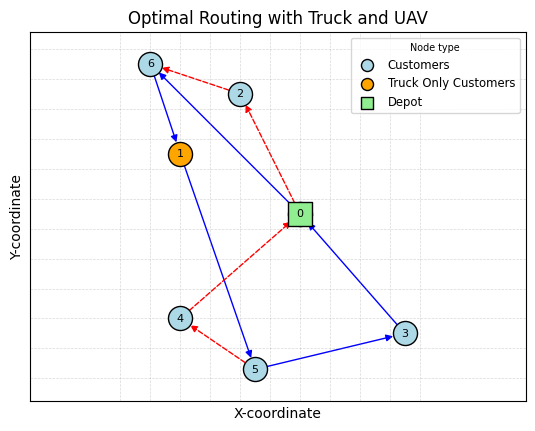

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

if mo.num_solutions:
    # Create a directed graph
    G = nx.DiGraph()

    # And 'N' is the set of all nodes, including the depot
    G.add_nodes_from(N)
    pos = {node: (x, y) for node, x, y in zip(N, coordinates['x'], coordinates['y'])}

    # Define node colors based on their type (truck only or both)
    truck_only_nodes = [i for i in C_truck]  # Define how to identify truck only nodes
    node_colors = ['orange' if node in truck_only_nodes else 'lightblue' for node in G.nodes()]

    # Draw nodes with different classifications
    customer_nodes = [node for node in G.nodes() if node not in truck_only_nodes and node != 0]
    nx.draw_networkx_nodes(G, pos, nodelist=customer_nodes, node_color='lightblue', edgecolors='black', node_size=300, label='Customers')
    nx.draw_networkx_nodes(G, pos, nodelist=truck_only_nodes, node_color='orange', edgecolors='black', node_size=300, label='Truck Only Customers')
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color='lightgreen', edgecolors='black', node_size=300, node_shape='s', label='Depot')

    # Draw edges and add labels to legend
    truck_edges = [(i, j) for i, j in x_ij if x_ij[i, j].x >= 0.99]
    uav_edges = [(i, j) for i, j, k in y_ijk if y_ijk[i, j, k].x >= 0.99] + [(j, k) for i, j, k in y_ijk if y_ijk[i, j, k].x >= 0.99]
    nx.draw_networkx_edges(G, pos, edgelist=truck_edges, width=1, edge_color='blue', style='solid', label='Truck Route')
    nx.draw_networkx_edges(G, pos, edgelist=uav_edges, width=1, edge_color='red', style='dashed', label='Drone Route')

    # Draw node labels
    for node, (x, y) in pos.items():
        if node != len(C)+1:  # Only label non-depot nodes
            plt.text(x, y, s=node, fontsize=8, ha='center', va='center')

    # Setup plot details
    plt.title('Optimal Routing with Truck and UAV')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.3)
    plt.xticks(range(int(min(coordinates['x'])) - 1, int(max(coordinates['x'])) + 2))
    plt.yticks(range(int(min(coordinates['y'])) - 1, int(max(coordinates['y'])) + 2))
    plt.axis('equal')

    # Create and position the legend
    legend = plt.legend(loc='best', fontsize='small', title="Node type", markerscale=0.5)
    plt.setp(legend.get_title(), fontsize='x-small')  # Set legend title font size

    # Show plot
    plt.show()

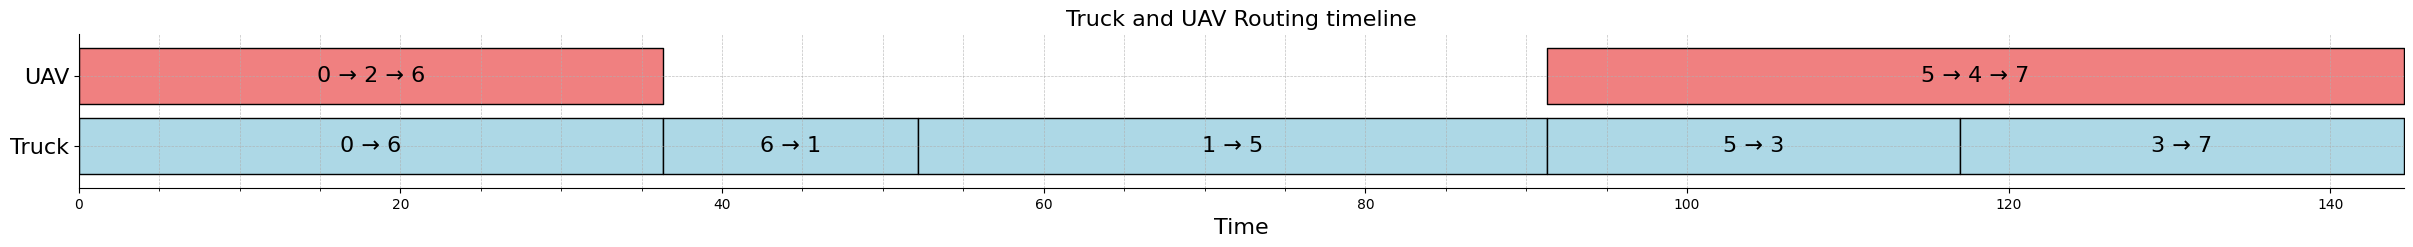

In [ ]:
import matplotlib.patches as patches

# Extract the time each truck and UAV reaches each node from the model's variables
truck_times = {int(v.name[1:]): v.x for v in mo.vars if v.name.startswith('t') and not v.name.startswith('t_prime')}
uav_times = {int(v.name[7:]): v.x for v in mo.vars if v.name.startswith('t_prime')}

# Define the sequence of nodes visited by the truck and UAV
# For instance, we can retrieve this from the model solution as well
truck_route = [0, 6, 1, 5, 3, 7]
uav_sorties = [(0, 2, 6), (5,4,7)]

# Start plotting
fig, ax = plt.subplots(figsize=(30, 2))

# Define a starting point for the bars
truck_start_time = 0
uav_start_time = 0

# Plot the truck route segments
for i in range(len(truck_route)-1):
    start_node = truck_route[i]
    end_node = truck_route[i+1]
    duration = truck_times[end_node] - truck_times[start_node]
    ax.broken_barh([(truck_times[start_node], duration)], (0.02, 0.08), facecolors='lightblue', edgecolor='black')
    label = f"{start_node} → {end_node}"
    text_x = truck_times[start_node]+duration/2
    ax.text(text_x, 0.06, label, fontsize=16,  ha='center', va='center')
    truck_start_time += duration


# Plot the UAV sortie segments
for sortie in uav_sorties:
    start_node, j, end_node = sortie
    duration = uav_times[end_node] - uav_times[start_node]
    uav_start_time = uav_times[start_node]
    ax.broken_barh([(uav_start_time, duration)], (0.12, 0.08), facecolors='lightcoral', edgecolor='black')
    label = f"{start_node} → {j} → {end_node}"
    text_x = truck_times[start_node]+duration/2
    ax.text(text_x, 0.16, label, fontsize=16,  ha='center', va='center')
    uav_start_time += duration

# Customizing the plot
ax.set_xlabel('Time', fontsize=16)
ax.set_xticks(np.arange(0, 101, 5), minor=True)
ax.set_yticks([0.06, 0.16])
ax.set_yticklabels(['Truck', 'UAV'], fontsize=16)
ax.set_ylim(0, 0.22)
ax.set_xlim(0, truck_times[7]) #truck_start_time)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.8)
ax.set_title('Truck and UAV Routing timeline', fontsize=16)

# Remove spines and y-axis ticks
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


In [ ]:
!jupyter nbconvert --to html MIP_in_python__v2.ipynb

[NbConvertApp] Converting notebook MIP_in_python__v2.ipynb to html
[NbConvertApp] Writing 774275 bytes to MIP_in_python__v2.html
